In [25]:
import pandas as pd
import json
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    StratifiedKFold,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
)
from joblib import parallel_backend
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

label_mapping = {'STARFORMING': 0, 'STARBURST': 1}

galaxy_data = pd.read_csv("clean_data.csv")
galaxy_data['subclass'] = galaxy_data['subclass'].map(label_mapping)
galaxy_data = galaxy_data.head(1000)

all_inputs = galaxy_data.drop(columns=["subclass"]).values

galaxy_data_normalized = pd.read_csv("clean_data_normalized.csv")
galaxy_data_normalized = galaxy_data_normalized.head(1000)
galaxy_data_normalized['subclass'] = galaxy_data_normalized['subclass'].map(label_mapping)
all_inputs_normalized = galaxy_data_normalized.drop(columns=["subclass"]).values

all_labels = galaxy_data["subclass"].values
nr_features = all_inputs.shape[1]

In [26]:
(
    training_inputs, 
    testing_inputs, 
    training_classes, 
    testing_classes
) = train_test_split(all_inputs, all_labels, test_size=0.25)

In [27]:
(
    training_inputs_normalized,
    testing_inputs_normalized,
    training_classes_normalized,
    testing_classes_normalized,
) = train_test_split(all_inputs_normalized, all_labels, test_size=0.25)

In [28]:
under_sampler = RandomUnderSampler()
inputs_under_sampl, labels_under_sampl = under_sampler.fit_resample(
    all_inputs, all_labels
)
inputs_under_sampl_normalized, labels_under_sampl_normalized = (
    under_sampler.fit_resample(all_inputs_normalized, all_labels)
)

len(inputs_under_sampl[labels_under_sampl == 1]), len(
    inputs_under_sampl[labels_under_sampl == 0]
)

(236, 236)

In [29]:
over_sampler = RandomOverSampler()
inputs_over_sampl, labels_over_sampl = over_sampler.fit_resample(all_inputs, all_labels)
inputs_over_sampl_normalized, labels_over_sampl_normalized = over_sampler.fit_resample(
    all_inputs_normalized, all_labels
)

len(inputs_over_sampl[labels_over_sampl == 1]), len(
    inputs_over_sampl[labels_over_sampl == 0]
)

(764, 764)

In [30]:
def json_to_dict(filename):
    with open(filename, "r") as f:
        return json.load(f)
    
best_params = json_to_dict("best_params.json")

In [31]:
def train_classifier(
    classifier,
    data,
    labels,
):
    with parallel_backend("loky"):
        classifier.fit(data, labels)
    print("Classifier trained")

    return classifier

In [32]:
def plot_measures(
    parameter: str,
    parameter_label: str,
    parameter_values: list,
    gridcv_results: dict,
    score_measures: list[str],
    filename: str,
):
    result = {measure: [0 for _ in parameter_values] for measure in score_measures}

    params = gridcv_results["params"]
    for measure in score_measures:
        scores = gridcv_results[measure]
        for i, p in enumerate(params):
            value_index = parameter_values.index(p[parameter])
            result[measure][value_index] = max(result[measure][value_index], scores[i])

    plt.figure(figsize=(15, 10))
    for measure in score_measures:
        plt.plot(parameter_values, result[measure], label=measure)

    plt.xlabel(parameter_label)
    plt.ylabel("Metric Value")
    plt.title(f"Metrics evolution with {parameter_label}")
    plt.legend()
    plt.xticks(parameter_values)

    plt.savefig(filename)


def print_classification_report(
    model, testing_inputs, testing_classes, show_feature_importances=True
):
    # plot histogarm with feature importance
    if show_feature_importances:
        plt.bar(
            galaxy_data.drop(columns=["subclass"]).columns, model.feature_importances_
        )
        plt.xticks(rotation=90)

    print(classification_report(testing_classes, model.predict(testing_inputs)))

    cf_matrix = confusion_matrix(testing_classes, model.predict(testing_inputs))
    cm = ConfusionMatrixDisplay(cf_matrix, display_labels=model.classes_)
    cm.plot()
    plt.show()

## Decision Tree

In [33]:
decision_tree_classifier = DecisionTreeClassifier(
    **best_params["Decision Tree"]
)

trained_decision_tree = train_classifier(
    decision_tree_classifier,
    all_inputs,
    all_labels,
)

Classifier trained


              precision    recall  f1-score   support

           0       0.99      0.99      0.99       191
           1       0.97      0.98      0.97        59

    accuracy                           0.99       250
   macro avg       0.98      0.99      0.98       250
weighted avg       0.99      0.99      0.99       250



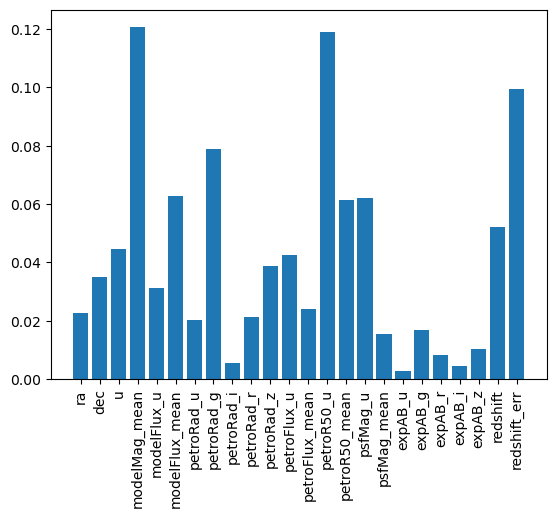

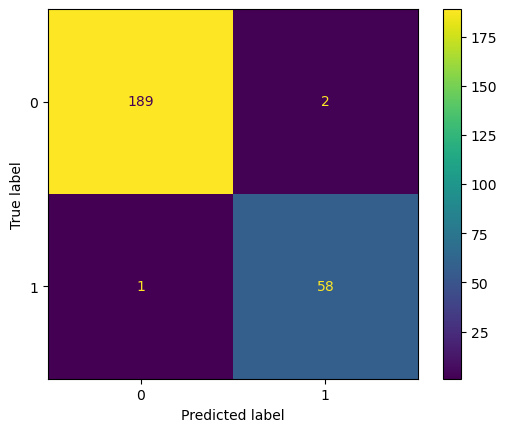

In [34]:
print_classification_report(trained_decision_tree, testing_inputs, testing_classes)

## K-NN: Nearest Neighbour

In [35]:
nearest_neighbour = KNeighborsClassifier(
    **best_params["KNN"]
)

trained_nearest_neighbour = train_classifier(
    nearest_neighbour,
    all_inputs,
    all_labels,
)

Classifier trained


              precision    recall  f1-score   support

           0       0.86      0.95      0.90       191
           1       0.75      0.51      0.61        59

    accuracy                           0.84       250
   macro avg       0.81      0.73      0.75       250
weighted avg       0.84      0.84      0.83       250



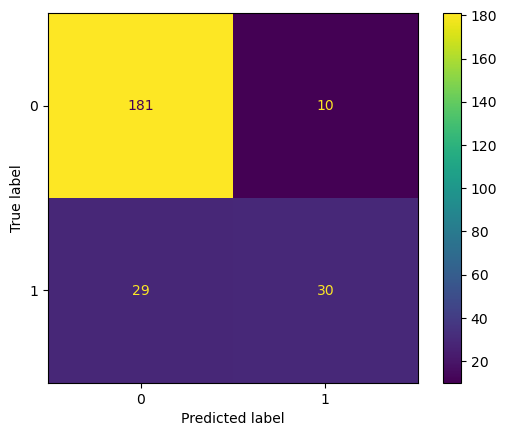

In [36]:
print_classification_report(trained_nearest_neighbour, testing_inputs, testing_classes, False)

## SVM: Support Vector Machine

In [37]:
svm = SVC(
    max_iter=100000,
    **best_params["SVM"]
)

trained_svm = train_classifier(
    svm,
    all_inputs,
    all_labels,
)

Classifier trained


              precision    recall  f1-score   support

           0       1.00      0.99      1.00       191
           1       0.98      1.00      0.99        59

    accuracy                           1.00       250
   macro avg       0.99      1.00      0.99       250
weighted avg       1.00      1.00      1.00       250



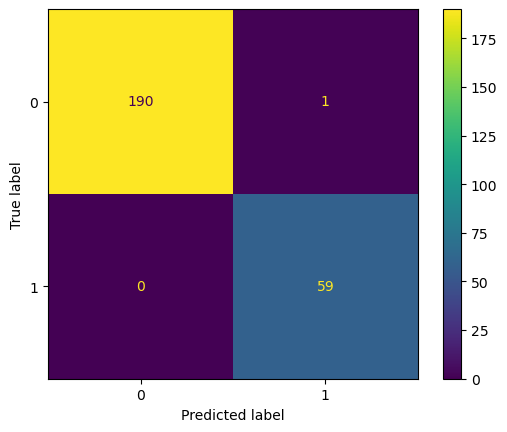

In [38]:
print_classification_report(trained_svm, testing_inputs, testing_classes, False)

## Redes Neuronais

In [39]:
neural_networks = MLPClassifier(
    **best_params["Neural Network"]
)

trained_neural_networks = train_classifier(
    neural_networks,
    all_inputs,
    all_labels,
)

Classifier trained


/home/dotw/anaconda3/lib/python3.11/site-packages/sklearn/neural_network/_multilayer_perceptron.py:541: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


              precision    recall  f1-score   support

           0       0.92      0.23      0.37       194
           1       0.26      0.93      0.40        56

    accuracy                           0.39       250
   macro avg       0.59      0.58      0.39       250
weighted avg       0.77      0.39      0.38       250



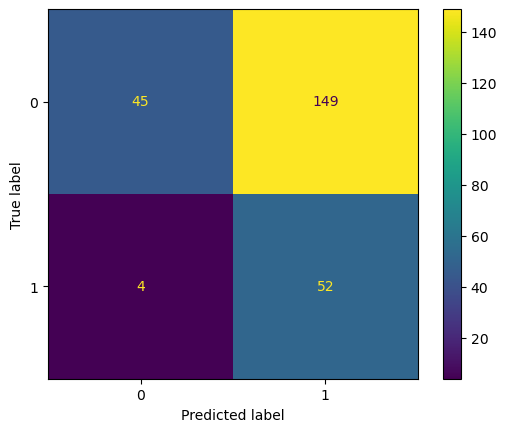

In [40]:
print_classification_report(
    trained_neural_networks,
    testing_inputs_normalized,
    testing_classes_normalized,
    False,
)